# TODOs

- filter books on valid ISBN, or try to correct them (at least trip some characters around)
- some of values in ISBN field are not valid ISBNs, but they are Amazon IDs (ASIN) -> remove them
- duplicate book entried - merge them
- plot plot_groupby_stats() after normalization

# Reading in data

In [1]:
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

--2021-11-07 20:13:48--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)|132.230.105.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘BX-CSV-Dump.zip’

BX-CSV-Dump.zip     100%[===================>]  24.88M  11.4MB/s    in 2.2s    

2021-11-07 20:13:51 (11.4 MB/s) - ‘BX-CSV-Dump.zip’ saved [26085508/26085508]



In [2]:
!unzip BX-CSV-Dump.zip

Archive:  BX-CSV-Dump.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
import pandas as pd

In [4]:
users = pd.read_csv('BX-Users.csv')

ParserError: ignored

In [5]:
!head BX-Users.csv

"User-ID";"Location";"Age"
"1";"nyc, new york, usa";NULL
"2";"stockton, california, usa";"18"
"3";"moscow, yukon territory, russia";NULL
"4";"porto, v.n.gaia, portugal";"17"
"5";"farnborough, hants, united kingdom";NULL
"6";"santa monica, california, usa";"61"
"7";"washington, dc, usa";NULL
"8";"timmins, ontario, canada";NULL
"9";"germantown, tennessee, usa";NULL


In [6]:
users = pd.read_csv('BX-Users.csv', sep=';')

UnicodeDecodeError: ignored

In [4]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding = "ISO-8859-1")
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding = "ISO-8859-1")

ParserError: ignored

In [9]:
!head -n6452 BX-Books.csv | tail -n1

"0735201994";"Peterman Rides Again: Adventures Continue with the Real \"J. Peterman\" Through Life &amp; the Catalog Business";"John Peterman";"2000";"Prentice Hall Art";"http://images.amazon.com/images/P/0735201994.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0735201994.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0735201994.01.LZZZZZZZ.jpg"


In [5]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding = "ISO-8859-1", escapechar = "\\")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = "ISO-8859-1")
ratings.head(20)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


# Utility matrix - try no.1

In [ ]:
# do not try to run, you will run out of memory
# ratings_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

In [12]:
ratings.shape

(1149780, 3)

In [13]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

In [14]:
sparce_matrix = csr_matrix((ratings['Book-Rating'], (ratings['User-ID'], ratings['ISBN'])))

TypeError: ignored

In [15]:
# inspired by https://stackoverflow.com/a/53235048
def create_matrix(frame, user_col, item_col, rating_col):
    """
    creates the sparse user-item interaction matrix

    Parameters
    ----------
    frame : DataFrame
        implicit rating data

    user_col : str
        user column name

    item_col : str
        item column name

    ratings_col : str
        implicit rating column name
    """

    user_c = CategoricalDtype(sorted(frame[user_col].unique()), ordered=True)
    item_c = CategoricalDtype(sorted(frame[item_col].unique()), ordered=True)

    row = frame[user_col].astype(user_c).cat.codes
    col = frame[item_col].astype(item_c).cat.codes
    return csr_matrix((frame[rating_col], (row, col)), \
                              shape=(user_c.categories.size, item_c.categories.size))

In [16]:
sparse_matrix = create_matrix(ratings, 'User-ID', 'ISBN', 'Book-Rating')
sparse_matrix

<105283x340556 sparse matrix of type '<class 'numpy.longlong'>'
	with 1149780 stored elements in Compressed Sparse Row format>

# Sanity checks


## Sparsity

In [17]:
len(ratings) / (len(users) * len(books))

1.5193415119518724e-05

very sparse => collaborative filtering might not be the best option

## New users and items

In [61]:
len(users['User-ID']) - len(ratings['User-ID'].unique())

173575

In [62]:
len(books['ISBN']) - len(ratings['ISBN'].unique())

-69177

In [73]:
len(books['ISBN'])

271379

In [69]:
books['ISBN'][books['ISBN'].isin(ratings['ISBN'])]

0         0195153448
1         0002005018
2         0060973129
3         0374157065
4         0393045218
             ...    
271374    0440400988
271375    0525447644
271376    006008667X
271377    0192126040
271378    0767409752
Name: ISBN, Length: 270170, dtype: object

In [74]:
len(books['ISBN']) - len(books['ISBN'][books['ISBN'].isin(ratings['ISBN'])])

1209

We don't have ratings for 1209 books.

In [76]:
len(ratings['ISBN'].unique())

340556

In [77]:
ratings['ISBN'][ratings['ISBN'].isin(books['ISBN'])].unique()

array(['034545104X', '0155061224', '0446520802', ..., '0590907301',
       '0679752714', '0806917695'], dtype=object)

In [79]:
len(ratings['ISBN'].unique()) - len(ratings['ISBN'][ratings['ISBN'].isin(books['ISBN'])].unique())

70386

We don't have metadata for 70 386 books that have some rating.

many new users and items => collaborative filtering might not be the best option

# Data analysis

## General look

In [82]:
users.head(20)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [83]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [84]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


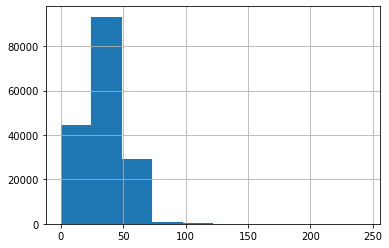

In [85]:
users['Age'].hist()

In [ ]:
u

In [86]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [88]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

In [90]:
books.head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


## Groupby

In [134]:
import matplotlib.pyplot as plt

def plot_groupby_stats(ratings):

  avg_user_rating = ratings.groupby('User-ID')["Book-Rating"].mean()
  num_ratings_by_user = ratings.groupby('User-ID')["Book-Rating"].count()
  avg_book_rating = ratings.groupby('ISBN')["Book-Rating"].mean()
  num_ratings_by_book = ratings.groupby('ISBN')["Book-Rating"].count()

  n_rows = 2
  n_cols = 2
  fig=plt.figure(figsize=(10, 10))

  ax = fig.add_subplot(n_rows, n_cols, 1)
  avg_user_rating.plot.box(ax=ax)
  ax.set_title("Average user rating")

  ax = fig.add_subplot(n_rows, n_cols, 2)
  num_ratings_by_user.plot.box(ax=ax)
  ax.set_title("Number of ratings by user")

  ax = fig.add_subplot(n_rows, n_cols, 3)
  avg_book_rating.plot.box(ax=ax)
  ax.set_title("Average book rating")

  ax = fig.add_subplot(n_rows, n_cols, 4)
  num_ratings_by_book.plot.box(ax=ax)
  ax.set_title("Number of ratings by book")

  fig.tight_layout()  # Improves appearance a bit.
  plt.show()


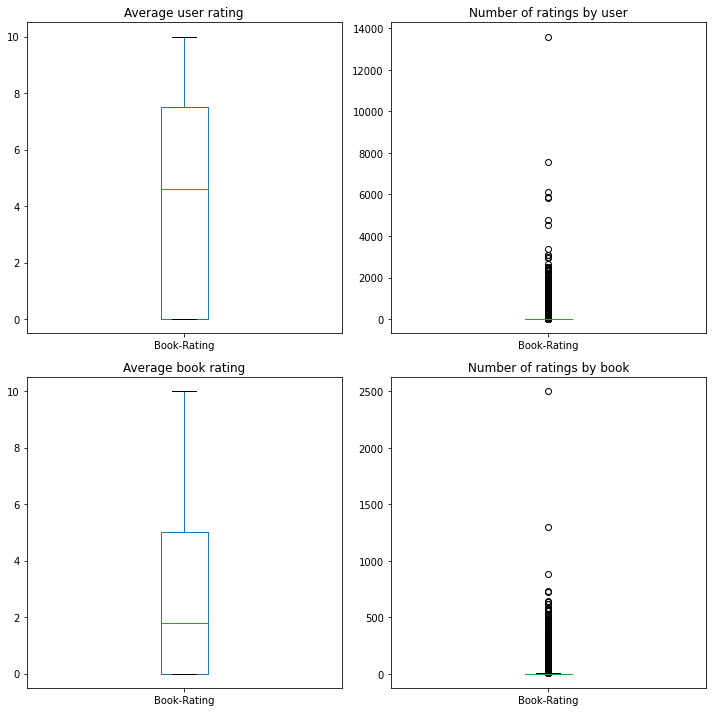

In [135]:
plot_groupby_stats(ratings)

## ISBN check





In [9]:
!pip install isbnlib

     |████████████████████████████████| 65 kB 4.3 MB/s 


In [27]:
# inspired by https://stackoverflow.com/a/38354322

import isbnlib

isbn = books['ISBN'][0]

book = isbnlib.meta(isbn, service='goob')
print(book)

book = isbnlib.meta(isbn, service='wiki')
print(book)

book = isbnlib.meta(isbn, service='openl')
print(book)

{'ISBN-13': '9780195153446', 'Title': 'Classical Mythology', 'Authors': ['Mark P. O. Morford', 'Robert J. Lenardon'], 'Publisher': 'Oxford University Press, USA', 'Year': '2003', 'Language': 'en'}
{'ISBN-13': '9780195153446', 'Title': 'Classical mythology', 'Authors': ['Mark P O Morford'], 'Publisher': 'Oxford University Press', 'Year': '2003', 'Language': ''}
{'ISBN-13': '9780195153446', 'Title': 'Classical mythology', 'Authors': ['Mark P. O. Morford'], 'Publisher': 'Oxford University Press', 'Year': '2003', 'Language': ''}


In [13]:
books.iloc[0]

ISBN                                                          0195153448
Book-Title                                           Classical Mythology
Book-Author                                           Mark P. O. Morford
Year-Of-Publication                                                 2002
Publisher                                        Oxford University Press
Image-URL-S            http://images.amazon.com/images/P/0195153448.0...
Image-URL-M            http://images.amazon.com/images/P/0195153448.0...
Image-URL-L            http://images.amazon.com/images/P/0195153448.0...
Name: 0, dtype: object

In [18]:
books['ISBN'].apply(lambda x: isbnlib.is_isbn10(x) or isbnlib.is_isbn13(x)).value_counts()

True     271262
False       117
Name: ISBN, dtype: int64

In [23]:
books[books['ISBN'].apply(lambda x: (not isbnlib.is_isbn10(x)) and (not isbnlib.is_isbn13(x)))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6291,B00009ANY9,Cane River,Lalita Tademy,2001,Warner Books,http://images.amazon.com/images/P/B00009ANY9.0...,http://images.amazon.com/images/P/B00009ANY9.0...,http://images.amazon.com/images/P/B00009ANY9.0...
10273,B0000A2U93,Carmilla,Joseph Sheridan Le Fanu,0,Soft Editions Ltd,http://images.amazon.com/images/P/B0000A2U93.0...,http://images.amazon.com/images/P/B0000A2U93.0...,http://images.amazon.com/images/P/B0000A2U93.0...
11186,B0000633PU,The Story of Aladdin and the Wonderful Lamp,S. Lane Poole,0,Renaissance eBooks,http://images.amazon.com/images/P/B0000633PU.0...,http://images.amazon.com/images/P/B0000633PU.0...,http://images.amazon.com/images/P/B0000633PU.0...
13863,B00007FYKO,Bloodcurdling Tales of Horror and the Macabre:...,H. P. Lovecraft,0,Ballantine,http://images.amazon.com/images/P/B00007FYKO.0...,http://images.amazon.com/images/P/B00007FYKO.0...,http://images.amazon.com/images/P/B00007FYKO.0...
13866,B00009APKU,Moby Dick,Herman Melville,0,"Outrigger Publishing, LLC",http://images.amazon.com/images/P/B00009APKU.0...,http://images.amazon.com/images/P/B00009APKU.0...,http://images.amazon.com/images/P/B00009APKU.0...
...,...,...,...,...,...,...,...,...
252085,B00013AX9E,Modern Contemporary: Aspects of Art at MoMA Si...,P Ed Varnedoe/Antonelli Kick,2000,Museum of Modern Arts,http://images.amazon.com/images/P/B00013AX9E.0...,http://images.amazon.com/images/P/B00013AX9E.0...,http://images.amazon.com/images/P/B00013AX9E.0...
256461,B00009NDBF,Help Yourself: Celebrating the Rewards of Resi...,David J. Pelzer,1900,E P Dutton,http://images.amazon.com/images/P/B00009NDBF.0...,http://images.amazon.com/images/P/B00009NDBF.0...,http://images.amazon.com/images/P/B00009NDBF.0...
262570,B000023VWR,The Postman Always Rings Twice,James Mallahan Cain,1996,Otto Penzler,http://images.amazon.com/images/P/B000023VWR.0...,http://images.amazon.com/images/P/B000023VWR.0...,http://images.amazon.com/images/P/B000023VWR.0...
264226,B00007CWGV,Madonna,Andrew Morton,2001,St. Martin's Press,http://images.amazon.com/images/P/B00007CWGV.0...,http://images.amazon.com/images/P/B00007CWGV.0...,http://images.amazon.com/images/P/B00007CWGV.0...


We have some ASIN (Amazon ID) codes instead of ISBN. Also, some Year-Of-Publication are missing.

In [28]:
book = isbnlib.meta('B00009ANY9', service='goob')
print(book)

NotValidISBNError: ignored

In [43]:
len(books)

271379

In [44]:
len(books['ISBN'].unique())

271379

In [49]:
len(books['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x))).unique())

270948

In [50]:
books['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x))).value_counts()

              117
037329171X      2
067144171X      2
037371128X      2
225303956X      2
             ... 
0804120013      1
3498029428      1
1853262889      1
3596505526      1
3789280631      1
Name: ISBN, Length: 270948, dtype: int64

In [51]:
books['ISBN']['037329171X']

KeyError: ignored

## Duplicates

In [64]:
counts = books['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x))).value_counts()
counts = counts[counts > 1]
counts

              117
037329171X      2
067144171X      2
037371128X      2
225303956X      2
             ... 
042507448X      2
068486441X      2
156389663X      2
087773402X      2
043936213X      2
Name: ISBN, Length: 316, dtype: int64

In [71]:
duplicate_isbn = counts.index
duplicate_isbn

Index(['', '037329171X', '067144171X', '037371128X', '225303956X',
       '078686298X', '037541181X', '042517400X', '034539092X', '067173685X',
       ...
       '034543773X', '051513581X', '039505155X', '037376099X', '080410297X',
       '042507448X', '068486441X', '156389663X', '087773402X', '043936213X'],
      dtype='object', length=316)

In [72]:
duplicates = books[
    books['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x)) in duplicate_isbn)
]
duplicates

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
66,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...
139,038572179X,Atonement : A Novel,IAN MCEWAN,2003,Anchor,http://images.amazon.com/images/P/038572179X.0...,http://images.amazon.com/images/P/038572179X.0...,http://images.amazon.com/images/P/038572179X.0...
157,044651747X,Puerto Vallarta Squeeze,Robert James Waller,1995,Warner Books,http://images.amazon.com/images/P/044651747X.0...,http://images.amazon.com/images/P/044651747X.0...,http://images.amazon.com/images/P/044651747X.0...
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
363,038542471X,The Client,John Grisham,1993,Doubleday Books,http://images.amazon.com/images/P/038542471X.0...,http://images.amazon.com/images/P/038542471X.0...,http://images.amazon.com/images/P/038542471X.0...
...,...,...,...,...,...,...,...,...
269316,055215038X,The Sleeper,Gillian White,2003,Corgi Books,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...
269571,037376099x,Patient Nurse (Man Of The Month) (Harlequin D...,Diana Palmer,1997,Silhouette,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...
270304,189481505X,I-O,Simon Logan,2002,Prime (OH),http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...
270502,039304632x,The Voyage of the Narwhal,Andrea Barrett,1998,W W Norton &amp; Co Inc,http://images.amazon.com/images/P/039304632X.0...,http://images.amazon.com/images/P/039304632X.0...,http://images.amazon.com/images/P/039304632X.0...


In [81]:
duplicates[duplicates['Book-Author'].apply(lambda x: 'Anne Tyler' in x)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
66,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...
210805,042511774x,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...


In [84]:
ratings[ratings['ISBN'].apply(lambda x: x in ['042511774X'])]

,User-ID,ISBN,Book-Rating
1117,277195,042511774X,0
8990,278535,042511774X,0
9638,67,042511774X,0
9993,243,042511774X,0
28464,6575,042511774X,0
...,...,...,...
1111311,266457,042511774X,8
1122990,269566,042511774X,0
1130485,271284,042511774X,0
1132522,271593,042511774X,0


In [85]:
ratings[ratings['ISBN'].apply(lambda x: x in ['042511774x'])]

,User-ID,ISBN,Book-Rating
512932,124487,042511774x,0


In [88]:
dup_zero = isbnlib.canonical(isbnlib.clean(duplicates['ISBN'][66]))
duplicates[duplicates['ISBN'].apply(lambda x: dup_zero in isbnlib.canonical(isbnlib.clean(x)))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
66,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...
210805,042511774x,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...,http://images.amazon.com/images/P/042511774X.0...


## Books metadata

In [33]:
books[books['Book-Title'].apply(lambda x: 'Potter' in x)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
821,0767908473,The Sorcerer's Companion: A Guide to the Magic...,ALLAN ZOLA KRONZEK,2001,Broadway,http://images.amazon.com/images/P/0767908473.0...,http://images.amazon.com/images/P/0767908473.0...,http://images.amazon.com/images/P/0767908473.0...
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
...,...,...,...,...,...,...,...,...
257280,043955490X,Harry Potter and the Goblet of Fire (Harry Pot...,J. K. Rowling,2003,Arthur A. Levine Books,http://images.amazon.com/images/P/043955490X.0...,http://images.amazon.com/images/P/043955490X.0...,http://images.amazon.com/images/P/043955490X.0...
259628,0939173344,Harry Potter and the Sorcerer's Stone,J.K. Rowling,1999,"National Braille Press, Inc.",http://images.amazon.com/images/P/0939173344.0...,http://images.amazon.com/images/P/0939173344.0...,http://images.amazon.com/images/P/0939173344.0...
260783,055329265X,Potter's Fields,Frank Roderus,1996,Bantam Books,http://images.amazon.com/images/P/055329265X.0...,http://images.amazon.com/images/P/055329265X.0...,http://images.amazon.com/images/P/055329265X.0...
263414,0785311122,Treasury of Beatrix Potter,Not Applicable (Na ),1995,Publications Intl,http://images.amazon.com/images/P/0785311122.0...,http://images.amazon.com/images/P/0785311122.0...,http://images.amazon.com/images/P/0785311122.0...


In [37]:
books[books.apply(lambda x: 'Potter' in x['Book-Title'] and 'Rowling' in x['Book-Author'], axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
...,...,...,...,...,...,...,...,...
234626,0439294827,Harry Potter and the Sorcerer's Stone: A Delux...,J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439294827.0...,http://images.amazon.com/images/P/0439294827.0...,http://images.amazon.com/images/P/0439294827.0...
237878,3895849618,Harry Potter und der Gefangene von Askaban. So...,Joanne K. Rowling,2002,Dhv der HÃ¶rverlag,http://images.amazon.com/images/P/3895849618.0...,http://images.amazon.com/images/P/3895849618.0...,http://images.amazon.com/images/P/3895849618.0...
251249,847888663X,Harry Potter y El Caliz de Fuego,J. K. Rowling,2001,Lidiun,http://images.amazon.com/images/P/847888663X.0...,http://images.amazon.com/images/P/847888663X.0...,http://images.amazon.com/images/P/847888663X.0...
257280,043955490X,Harry Potter and the Goblet of Fire (Harry Pot...,J. K. Rowling,2003,Arthur A. Levine Books,http://images.amazon.com/images/P/043955490X.0...,http://images.amazon.com/images/P/043955490X.0...,http://images.amazon.com/images/P/043955490X.0...


In [42]:
book = isbnlib.meta('3895849618', service='goob')
print(book)

book = isbnlib.meta('3895849618', service='wiki')
print(book)

book = isbnlib.meta('3895849618', service='openl')
print(book)

{}
{'ISBN-13': '9783895849619', 'Title': 'Harry Potter und der Gefangene von Askaban', 'Authors': ['Joanne K Rowling', 'Rufus Beck'], 'Publisher': 'Joanne K. Rowling', 'Year': '2002', 'Language': ''}
{'ISBN-13': '9783895849619', 'Title': 'Harry Potter und der Gefangene von Askaban', 'Authors': ['J. K. Rowling'], 'Publisher': 'Dhv der Hörverlag', 'Year': '2002', 'Language': ''}


## Users metadata

In [18]:
users['Location'].apply(lambda x: x.split(',')[-1]).value_counts()

 usa                                      139711
 canada                                    21658
 united kingdom                            18538
 germany                                   17043
 spain                                     13147
                                           ...  
 fredonia - land of the brave and free         1
 w. malaysia                                   1
 united kindgdom                               1
 la chine éternelle!                           1
 ferrara                                       1
Name: Location, Length: 709, dtype: int64

In [20]:
countries = users['Location'].apply(lambda x: x.split(',')[-1].strip('\"')).value_counts()
countries 

 usa                                      139712
 canada                                    21658
 united kingdom                            18556
 germany                                   17073
 spain                                     13258
                                           ...  
 the philippines                               1
 slovak republik                               1
 w. malaysia                                   1
 fredonia - land of the brave and free         1
 st. clair                                     1
Name: Location, Length: 631, dtype: int64